In [14]:
# All required Imports 
import os
import time
import copy
import imageio
import functools
import cv2 as cv
import numpy as np
import scipy.io as io
import sklearn
from sklearn.feature_extraction import image
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Accessing Data Set

In [15]:
def load_dataset(dataset, scale_factor):
    data = {}
    if dataset == 'kitti':
        # Minimum and maximum disparies
        data['min_disparity'] = 0//scale_factor
        data['max_disparity'] = 150//scale_factor
        # Cam pose
        calib = io.loadmat('./data/kitti/pose_and_K.mat')
        data['kmat'] = calib['K']
        data['baseline']= calib['Baseline']
        data['kmat'][0:2,0:2] /= scale_factor
        data['focal_length'] = data['kmat'][0,0]
        left_img_path = './data/kitti/left.png'
        right_img_path = './data/kitti/right.png'    
        data['max_depth'] = 650
    elif dataset == 'medieval_port':
        # Minimum and maximum disparies
        data['min_disparity'] = 0//scale_factor
        data['max_disparity'] = 80//scale_factor

        # Cam pose
        data['kmat'] = np.array([[700.0000,   0.0000, 320.0000],
                [0.0000, 933.3333, 240.0000],
                [0.0000,   0.0000,   1.0000]], dtype=np.float32)
        data['kmat'][:2, :] = data['kmat'][:2, :]/scale_factor
        data['focal_length'] = data['kmat'][0,0]
        data['baseline']= 0.5
        left_img_path = './data/medieval_port/left.jpg'
        right_img_path = './data/medieval_port/right.jpg'
        data['max_depth'] = 25
    else:
        assert False, 'Dataset Error'

    # Read Images
    l_im = cv.imread(left_img_path, 1)
    r_im = cv.imread(right_img_path, 1)
    h, w, c = l_im.shape
    data['resized_l_img'] = cv.resize(l_im, (w//scale_factor, h//scale_factor))
    data['resized_r_img'] = cv.resize(r_im, (w//scale_factor, h//scale_factor))

    # plot left and right images
    stacked_imgs = np.concatenate([data['resized_l_img'], data['resized_r_img']], axis=1)
    plt.imshow(stacked_imgs[..., [2, 1, 0]])
    plt.show()
    return data

### Utility Function

In [16]:
def copy_make_border(img, patch_width):
    """
    This function applies cv.copyMakeBorder to extend the image by patch_width/2
    in top, bottom, left and right part of the image
    Patches/windows centered at the border of the image need additional padding of size patch_width/2
    """
    offset = np.int(patch_width/2.0)
    return cv.copyMakeBorder(img, 
                             top=offset, bottom=offset,
                             left=offset, right=offset, 
                             borderType=cv.BORDER_REFLECT)

def extract_patches(img, patch_width):
    '''
    Input:
        image: size[h, w, 3]
    Return:
        patches: size[h, w, patch_width*patch_width*c]
    '''
    if img.ndim==3:
        h, w, c = img.shape
    else:
        h, w = img.shape
        c = 1
    img_padded = copy_make_border(img, patch_width)
    patches = image.extract_patches_2d(img_padded, (patch_width, patch_width))
    patches = patches.reshape(h, w, patch_width, patch_width, c)
    return patches

# This function is used to calculate the running time required by the function
def timeit(func):
    functools.wraps(func)
    def wrapper(*args, **kwargs):
        t_start = time.time()
        out = func(*args, **kwargs)
        print(f'Elapsed time == {time.time() - t_start}')
        return out
    return wrapper

### Pixel-Based Matching

For each pixel in the left image, finding the corresponding pixel in the right image using a **pixel-based** cost function, i.e. the difference between individual left and right pixels. Basically applying ***SAD (Sum of Squared Differences)***

loading dataset


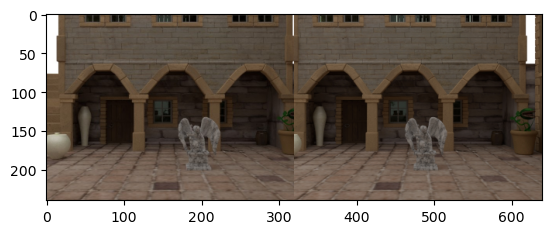

running...


C:\Users\Tanmay\AppData\Local\Temp\ipykernel_10096\22063542.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  abs_val=abs(feature_1-feature_2)


Elapsed time == 30.600029706954956


'Disparity'

array([[255, 255, 255, ...,  72, 255, 255],
       [255, 255, 255, ...,  72, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [113, 111, 108, ..., 255, 104, 255],
       [105, 104, 100, ..., 255, 255, 255],
       [115, 116, 115, ..., 255,  92,  92]])

finished


In [21]:
def abs_(feature_1, feature_2):
    '''
    Absolute difference between individual gray scale pixels.
    inputs: feature_1 and feature_2 with shape[h, w, 1]
    return: per pixel distance
    '''
    #Your implementation goes here
    abs_val=abs(feature_1-feature_2)
    return abs_val


@timeit
def pixel_based_stereo_matching(img_left, img_right):
    '''
    Compare each pixel in the left image with those in the right image.
    '''
    #Your implementation goes here
    l=img_left
    r=img_right
    h_l,w_l=l.shape
    h_r,w_r=l.shape
    disparity=np.full((h_l,w_l),255,dtype=int)        
    for i in range(h_r):
        buffer_r_row=r[i,:]
        buffer_r_row=buffer_r_row.T
        buffer_l_row=l[i,:]
        buffer_l_row=buffer_l_row.T
        for j in range(len(buffer_r_row)):
            for k in range(len(buffer_l_row)):
                abs_value=abs_(buffer_l_row[k],buffer_r_row[j])
                if abs_value==0:
                    disparity[i,k]=buffer_l_row[k]
                    buffer_l_row[k]=0
                    break
    return disparity


dataset = 'medieval_port'
# dataset = 'kitti'
# dataset = 'office' #optional
scale_factor = 2                                                                                                                                            #downsamples images for shorter runtime while testing
print("loading dataset")
data = load_dataset(dataset, scale_factor)
print("running...")
disparity_abs = pixel_based_stereo_matching(cv.cvtColor(data['resized_l_img'], cv.COLOR_BGR2GRAY), cv.cvtColor(data['resized_r_img'], cv.COLOR_BGR2GRAY))
display("Disparity",disparity_abs)
print("finished")

Displaying ./results/pixel_disparity_medieval port.png


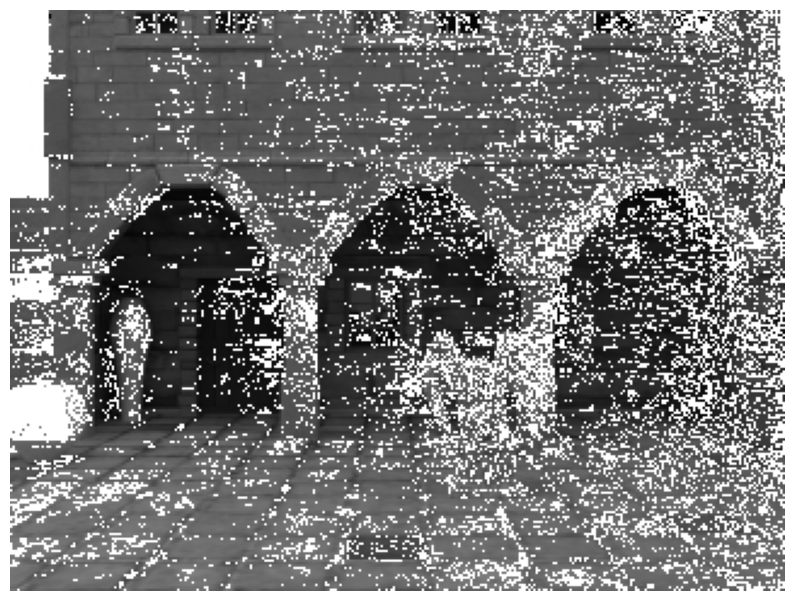

In [22]:
# Code to display the image
def disp_2_img(disparity):
    '''
    This function should convert disparities, which are distances, to a 3 channel gray scale image.
    Values are in range [0, 255].
    input: disparity with shape[h, w]
    return: disp_img with shape[h, w, 3]
    '''
    #Your implementation goes here
    buffer=np.dstack((disparity,disparity))
    disp_img=np.dstack((buffer,disparity))
    return disp_img

# get disparity image for visualisation
disparity_abs_img = disp_2_img(disparity_abs)

os.makedirs(f'./results', exist_ok=True)
disp_f_name = f'./results/pixel_disparity_medieval port.png'
cv.imwrite(disp_f_name, disparity_abs_img)

print(f'Displaying {disp_f_name}')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(cv.imread(disp_f_name)[..., [2,1,0]])

### Window Based Matching

For each pixel in the left image, finding the corresponding pixel in the right image using a **window-based** ***NCC (Normalized Cross Correlation)*** or ***SSD (Sum of Squared Differences)*** cost functions. For this, use a window size of $7x7$.

loading dataset


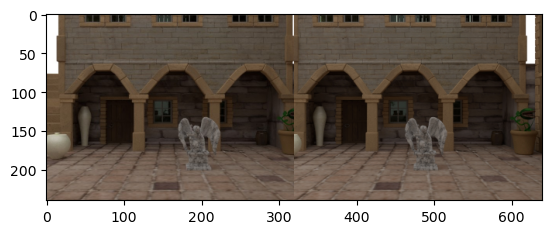

running stereo_matching with ncc...


C:\Users\Tanmay\AppData\Local\Temp\ipykernel_10096\4081464471.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  offset = np.int(patch_width/2.0)
C:\Users\Tanmay\AppData\Local\Temp\ipykernel_10096\4081464471.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note 

Elapsed time == 2890.7203104496
finished
Displaying ./results/medieval_port/ssd_disparity7x7.png


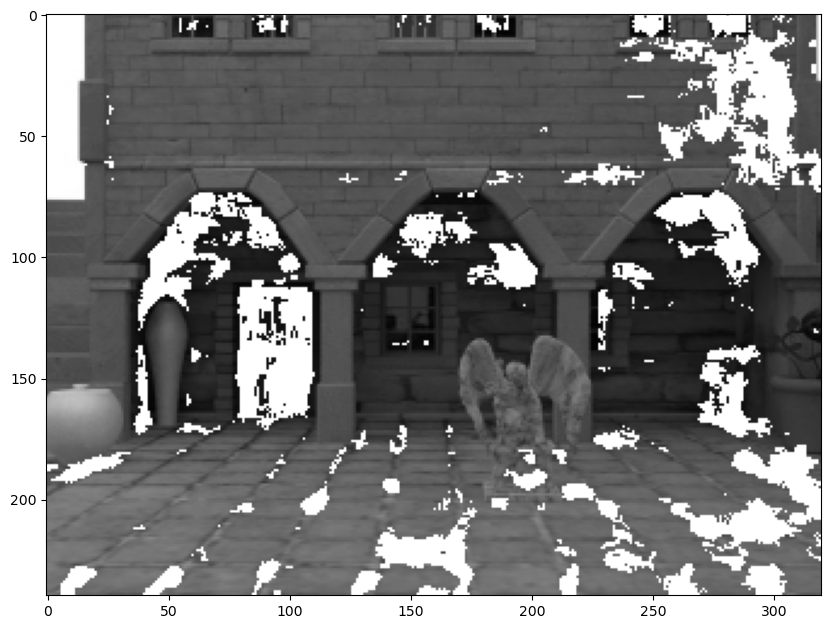

In [23]:
def ncc(feature_1, feature_2):
    '''
    Normalized Cross Validation
    inputs: feature_1, feature_2 with shape[h, w, k*k*c], where k = patch width, c = color channels
    return: per patch similarity, shape[h, w]
    '''
    #Your implementation goes here

    sum_kernel_l=0
    sum_kernel_r=0
    kernel_l=feature_1.flatten()
    kernel_r=feature_2.flatten()
    kernel_l=kernel_l.astype('int')
    kernel_r=kernel_r.astype('int')
    multiply=kernel_l*kernel_r
    numerator=np.sum(multiply)
    squared_kernel_l=np.square(kernel_l)
    squared_kernel_r=np.square(kernel_r)
    sum_kernel_l=np.sum(squared_kernel_l)
    sum_kernel_r=np.sum(squared_kernel_r)
    sum_kernel=sum_kernel_l*sum_kernel_r
    denominator=np.sum(sum_kernel)
    ncc_vals=numerator/denominator
    return ncc_vals

def ssd(feature_1, feature_2):
    '''
    Sum of Squared Differences
    inputs: feature_1, feature_2 with shape[h, w, k*k*c], where k = patch width, c = color channels
    '''
    ssd_val=0
    kernel_l=feature_1.flatten()
    kernel_r=feature_2.flatten()
    for i in range(len(kernel_l)):
        squared_difference=(kernel_l[i]-kernel_r[i])**2
        ssd_val=ssd_val+squared_difference
    return ssd_val

def index_condition(kernel,similarity_metric):
    if similarity_metric=='ssd':
        nearest_to_0=np.absolute(kernel) 
        index=nearest_to_0.argmin() 
    elif similarity_metric=='ncc':
        # greatest=np.absolute(kernel)
        index=kernel.argmax()
    return index

@timeit
def stereo_matching(img_left, img_right, patch_width, similarity_metric):
    '''
    Instead of comparing individual pixels, extract patches and compare them. (There is a utility function given for extracting patches)
    Compute similarity scores using ssd or ncc in order to find pixel matches.
    Compute the disparity based on the matches.
    input: img_left, img_right: shape[h, w, 3]
           patch_width: int
           similarity_metric: string
    return: disparity: shape[h, w]
            sim_scores: shape[h, w, d], where d is the number of disparities (this needs to be returned for usage in the next task)
    '''
    img_left=cv.cvtColor(img_left,cv.COLOR_BGR2GRAY)
    img_right=cv.cvtColor(img_right,cv.COLOR_BGR2GRAY)
    h_l,w_l=img_left.shape
    h_r,w_r=img_right.shape

    patch_l=extract_patches(img_left,patch_width)
    patch_r=extract_patches(img_right,patch_width)
    sim_scores=0
    disparity=np.full((h_l,w_l),255,dtype=int) 
    for i in range(h_r):
        buffer_l=patch_l[i,:,:]
        buffer_r=patch_r[i,:,:]  
        for j in range (len(buffer_r)):
            for k in range(len(buffer_l)):
                if similarity_metric=='ssd':
                    if k==0:
                        row=ssd(buffer_l[k],buffer_r[j])
                    else:
                        row1=ssd(buffer_l[k],buffer_r[j])
                        row=np.append(row,row1)
    
                elif similarity_metric=='ncc':
                    if k==0:
                        row=ncc(buffer_l[k],buffer_r[j])
                    else:
                        row1=ncc(buffer_l[k],buffer_r[j])
                        row=np.append(row,row1)

            index=index_condition(row,similarity_metric)
            disparity[i,index]=img_left[i,index]
            buffer_l[index]=0
    return disparity, sim_scores

dataset = 'medieval_port'
scale_factor = 2                                                                                                                            #downsamples images for shorter runtime while testing
print("loading dataset")
data = load_dataset(dataset, scale_factor)
patch_width = 7
print("running stereo_matching with ncc...")
similarity_metric = 'ssd'
disparity, _ = stereo_matching(copy.copy(data['resized_l_img']), copy.copy(data['resized_r_img']), patch_width, similarity_metric)
print("finished")

experiment = f'results/{dataset}'
os.makedirs(f'./{experiment}', exist_ok=True)

disparity_img = disp_2_img(disparity)
disp_f_name = f'./{experiment}/{similarity_metric}_disparity{patch_width}x{patch_width}.png'
cv.imwrite(disp_f_name, disparity_img)

print(f'Displaying {disp_f_name}')
plt.figure(figsize=(10,10))
plt.imshow(cv.imread(disp_f_name)[..., [2,1,0]])

Experimenting with different window sizes: $3x3,5x5,7x7,9x9,11x11,13x13,15x15,17x17$ pixels, and saving them to **ncc_disparity3x3.png**, **ncc_disparity5x5.png** and so on.

loading dataset


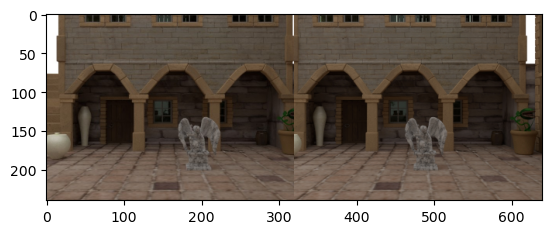

running stereo_matching...


C:\Users\Tanmay\AppData\Local\Temp\ipykernel_10096\4081464471.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  offset = np.int(patch_width/2.0)
C:\Users\Tanmay\AppData\Local\Temp\ipykernel_10096\4081464471.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note 

KeyboardInterrupt: 

In [24]:
#Experiment with different settings

# Select the dataset
dataset = 'medieval_port'
# dataset = 'kitti'
# dataset = 'office' #optional

# While experimenting it is better to work with a lower resolution version of the image
# Since the dataset is of high resolution we will work with down-scaled versions of the images.
# You can choose the reduction factor using the scale_factor variable.
scale_factor = 2

# Choose the similarity metric
similarity_metric = 'ssd'
# similarity_metric = 'ncc'

patch_width = 3                                                                                                 # Choose the patch size

# Load the dataset
print("loading dataset")
data = load_dataset(dataset, scale_factor)

experiment = f'results/exp_patch_size/{dataset}'
os.makedirs(f'./{experiment}', exist_ok=True)

# get disparity images for visualisation
print("running stereo_matching...")
disparity, _ = stereo_matching(data['resized_l_img'], data['resized_r_img'], patch_width, similarity_metric)
print("finished")
disparity_img = disp_2_img(disparity)

# save and display disparity
disp_f_name = f'./{experiment}/{similarity_metric}_disparity{patch_width}x{patch_width}.png'
cv.imwrite(disp_f_name, disparity_img)

print(f'Displaying {disp_f_name}')
plt.figure(figsize=(10,10))
plt.imshow(cv.imread(disp_f_name)[..., [2,1,0]])